## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]


reduce_lr_factor = [0.75, 0.5]
reduce_lr_patient = [2e-12, 1e-12]


Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=reduce_patient, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.75, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 3s 60us/step - loss: 1.3362 - acc: 0.5367 - val_loss: 1.5309 - val_acc: 0.4657
Epoch 12/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.3135 - acc: 0.5431 - val_loss: 1.5024 - val_acc: 0.4696
Epoch 13/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.2907 - acc: 0.5539 - val_loss: 1.4954 - val_acc: 0.4698
Epoch 14/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.2672 - acc: 0.5612 - val_loss: 1.4848 - val_acc: 0.4791
Epoch 15/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.2461 - acc: 0.5682 - val_loss: 1.4859 - val_acc: 0.4758
Epoch 16/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.2265 - acc: 0.5784 - val_loss: 1.4790 - val_acc: 0.4793
Epoch 17/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.2070 - acc: 0.5839 - val_loss: 1.4726 - val_acc: 0.4854
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 93us/step - loss: 2.2752 - acc: 0.2507 - val_loss: 2.1795 - val_acc: 0.2974
Epoch 2/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.7781 - acc: 0.3824 - val_loss: 1.8385 - val_acc: 0.3681
Epoch 3/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.6523 - acc: 0.4213 - val_loss: 1.7176 - val_acc: 0.4002
Epoch 4/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.5815 - acc: 0.4470 - val_loss: 1.6715 - val_acc: 0.4118
Epoch 5/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.5282 - acc: 0.4653 - val_loss: 1.6168 - val_acc: 0.4334
Epoch 6/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.4849 - acc: 0.4816 - val_loss: 1.6041 - val_acc: 0.4336
Epoch 7/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.4493 - acc: 0.4939 - val_loss: 1.5746 - val_acc

50000/50000 [==============================] - 3s 62us/step - loss: 0.4701 - acc: 0.8469 - val_loss: 1.9782 - val_acc: 0.4466

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.000421874981839.
Epoch 24/25
50000/50000 [==============================] - 3s 64us/step - loss: 0.4040 - acc: 0.8753 - val_loss: 1.7571 - val_acc: 0.4901
Epoch 25/25
50000/50000 [==============================] - 3s 63us/step - loss: 0.3712 - acc: 0.8902 - val_loss: 1.8967 - val_acc: 0.4741
Numbers of exp: 5, reduce_factor: 0.75, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_

50000/50000 [==============================] - 3s 61us/step - loss: 1.0563 - acc: 0.6326 - val_loss: 1.5536 - val_acc: 0.4574
Epoch 10/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.0097 - acc: 0.6495 - val_loss: 1.5058 - val_acc: 0.4771
Epoch 11/25
50000/50000 [==============================] - 3s 63us/step - loss: 0.9715 - acc: 0.6660 - val_loss: 1.4824 - val_acc: 0.4902
Epoch 12/25
50000/50000 [==============================] - 3s 63us/step - loss: 0.9310 - acc: 0.6828 - val_loss: 1.4750 - val_acc: 0.4938
Epoch 13/25
50000/50000 [==============================] - 3s 62us/step - loss: 0.8946 - acc: 0.6935 - val_loss: 1.5497 - val_acc: 0.4640
Epoch 14/25
50000/50000 [==============================] - 3s 63us/step - loss: 0.8562 - acc: 0.7099 - val_loss: 1.4979 - val_acc: 0.4939
Epoch 15/25
50000/50000 [==============================] - 3s 63us/step - loss: 0.8248 - acc: 0.7195 - val_loss: 1.5643 - val_acc: 0.4697
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.8054 - acc: 0.3742 - val_loss: 1.9895 - val_acc: 0.3352
Epoch 2/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.5333 - acc: 0.4588 - val_loss: 1.9297 - val_acc: 0.3467
Epoch 3/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.4306 - acc: 0.4933 - val_loss: 2.0591 - val_acc: 0.3114
Epoch 4/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.3555 - acc: 0.5212 - val_loss: 3.0913 - val_acc: 0.2330
Epoch 5/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.2880 - acc: 0.5459 - val_loss: 2.1244 - val_acc: 0.3411
Epoch 6/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.2422 - acc: 0.5611 - val_loss: 2.1227 - val_acc: 0.3056
Epoch 7/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.1972 - acc: 0.5781 - val_loss: 2.1840 - val_ac

50000/50000 [==============================] - 3s 62us/step - loss: 0.6609 - acc: 0.7800 - val_loss: 1.7236 - val_acc: 0.4729

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.000316406236379.
Epoch 23/25
50000/50000 [==============================] - 3s 62us/step - loss: 0.5928 - acc: 0.8088 - val_loss: 1.5977 - val_acc: 0.4932
Epoch 24/25
50000/50000 [==============================] - 3s 62us/step - loss: 0.5707 - acc: 0.8153 - val_loss: 1.6291 - val_acc: 0.4875
Epoch 25/25
50000/50000 [==============================] - 3s 63us/step - loss: 0.5470 - acc: 0.8250 - val_loss: 1.7077 - val_acc: 0.4730
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               15733

50000/50000 [==============================] - 3s 63us/step - loss: 1.2578 - acc: 0.5652 - val_loss: 1.5312 - val_acc: 0.4627
Epoch 9/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.2217 - acc: 0.5786 - val_loss: 1.5655 - val_acc: 0.4511
Epoch 10/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.1818 - acc: 0.5930 - val_loss: 1.5464 - val_acc: 0.4600
Epoch 11/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.1505 - acc: 0.6041 - val_loss: 1.5560 - val_acc: 0.4552
Epoch 12/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.1177 - acc: 0.6163 - val_loss: 1.5241 - val_acc: 0.4677
Epoch 13/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.0881 - acc: 0.6307 - val_loss: 1.5127 - val_acc: 0.4680
Epoch 14/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.0594 - acc: 0.6405 - val_loss: 1.5026 - val_acc: 0.4721
Epoch 15/25
50000/50000 [======================

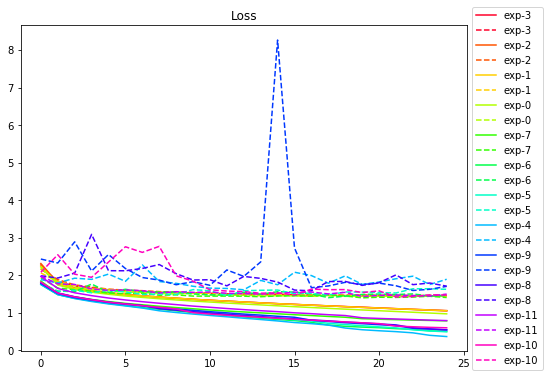

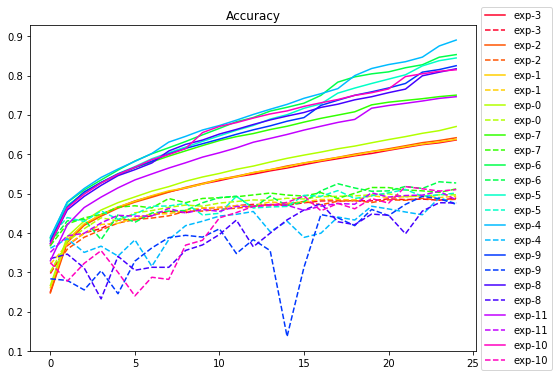

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()